# Data requirements for shoreline modelling ML

This analyis is based on the "optimised" model selected by CV exhaustive search.

Developed by Joshua Simmons 01/2019.

## Foreword
JupyterNB settings, load functions

In [1]:
#turn off for this training
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
####################
# Packages
####################

import pandas as pd
from ipywidgets import interact, fixed, IntSlider, SelectionSlider, SelectionRangeSlider, interact_manual
import pickle, os
import math
import scipy.stats as scistats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

####################
# Functions
####################

from functions.model_crossval import cv_CombineRuns, cv_LoadCombined, trainCombsGenerate, OLDtrainCombsGenerate
from functions.model_crossval import plot_CVprocessedResults
from functions.model_visualisation import *
from functions.model_datarequirements import prep_dataRequirements, dataReq_Frame

Using TensorFlow backend.


## Settings

In [3]:
cvNum = 18
_, dataStore, _, caseDict, allCVDF = cv_LoadCombined(cvCaseNum=cvNum)

cvNum = 24
_, satdataStore, _, satcaseDict, satallCVDF = cv_LoadCombined(cvCaseNum=cvNum)

cvNum = 26
_, satnoidataStore, _, satnoicaseDict, satnoiallCVDF = cv_LoadCombined(cvCaseNum=cvNum)

/Users/josh/anaconda3/envs/macle2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/josh/anaconda3/envs/macle2/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
allCVDF['label'] = ['Full']*allCVDF.shape[0]
satallCVDF['label'] = ['Reduced']*satallCVDF.shape[0]
satnoiallCVDF['label'] = ['Noise']*satallCVDF.shape[0]

plotData = pd.concat([allCVDF, satallCVDF, satnoiallCVDF], ignore_index=True, sort=False)

narra: 7.47
narra: 7.84
narra: 10.83
tairua: 4.83
tairua: 4.97
tairua: 7.36


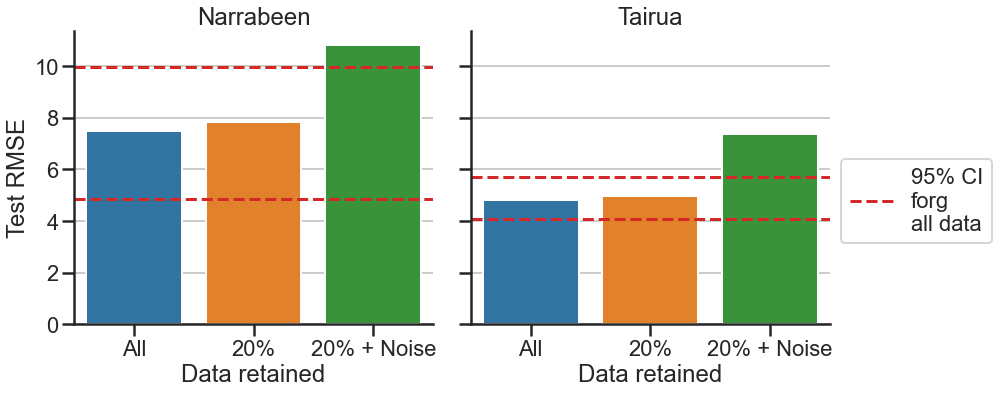

In [16]:
#seaborn plot
plotData = plotData[plotData['site'] != '']
stat = 'testRMSE'
# plotData = dataReqStore.melt(idvars=['CVFold','site','Run','dataPerc'])
# fig = plt.figure(figsize=(14,8))
# ax1 = fig.add_subplot(121)
#style with sns
sns.set_context("poster")
#sns.set(font_scale=1.8)
sns.set_style("ticks",{'axes.grid': True})
# g = sns.barplot(x='site', y=stat,
#                 hue='label',
#                 data=plotData[plotData['site']=='narra'],
#                 ax=ax1)
# ax2 = fig.add_subplot(122)
# g = sns.barplot(x='site', y=stat,
#                 hue='label',
#                 data=plotData[plotData['site']=='tairua'],
#                 ax=ax2)

for thisSite in plotData['site'].unique():
    for thisLab in plotData['label'].unique():
        print('{}: {:.2f}'.format(thisSite,plotData[(plotData['site']==thisSite)&(plotData['label']==thisLab)][stat].mean()))

g = sns.catplot(x='label', y=stat,
                #hue='label',
                col='site',
                kind='bar',
                height=6, aspect=1.2,
                ci=None,
                data=plotData)
#ax1.set_xlabel('Percentage of data used in training')
if 'NMSE' in stat:
    ylab = 'Test NMSE'
elif 'RMSE' in stat:
    ylab = 'Test RMSE'
else:
    ylab = 'Test R'
    
axs = g.axes
axs[0][0].set_title('Narrabeen')
axs[0][1].set_title('Tairua')

axs[0][0].axhline(np.percentile(plotData[(plotData['site']=='narra') & (plotData['label']=='Full')][stat].values,97.5),
                 0,1,color='C3', linestyle = 'dashed')
axs[0][0].axhline(np.percentile(plotData[(plotData['site']=='narra') & (plotData['label']=='Full')][stat].values,2.5),
                 0,1,color='C3', linestyle = 'dashed')

axs[0][1].axhline(np.percentile(plotData[(plotData['site']=='tairua') & (plotData['label']=='Full')][stat].values,97.5),
                 0,1,color='C3', linestyle = 'dashed')
axs[0][1].axhline(np.percentile(plotData[(plotData['site']=='tairua') & (plotData['label']=='Full')][stat].values,2.5),
                 0,1,color='C3', linestyle = 'dashed')

(g.set_axis_labels('Data retained', ylab)
    .set_xticklabels(['All', '20%', '20% + Noise'])) 

axs[0][1].legend(bbox_to_anchor=(1,0.6),loc=2,labels=['95% CI\nforg\nall data'])

plt.tight_layout()
savePath =  os.path.join('..', 'figures', 'dataReduce', 'dataReduce_case_' +
                         cvNum.__str__() + '_' + stat + '.png')
os.makedirs(os.path.dirname(savePath), exist_ok=True)
plt.savefig(savePath, dpi=600)